##### Sample 1 - Fitting and using factor models for risk  management

In this example we are fitting a simple fundamental factor moddel and a statistical one for an SX5E basket. </br>
We then perfrom some simple valiadation, use the model to project risk, and then set up an optimization problem.</br>
Finally let's compare the optimized portfolios to an equally weighted one.

- First load some cached data (Here we are just using some pickled files from simplicity as opposed to the DataHandler class)

In [18]:
from cached_data.utils import flexCachedir
import pickle, os, warnings, logging
warnings.filterwarnings("ignore");logging.disable(logging.CRITICAL)

returns_df = pickle.load(open(os.path.join(flexCachedir(),'dummy_returns_df.pkl'), 'rb'));returns_df200 = returns_df.tail(200)#cut down for demo
fund_data = pickle.load(open(os.path.join(flexCachedir(),'dummy_fund_data.pkl'), 'rb'));fund_data.index = fund_data.index.str.replace(' Equity','')#consistent format
portfolio_w = pickle.load(open(os.path.join(flexCachedir(),'dummy_portfolio_w.pkl'), 'rb'));portfolio_w.name = 'Weight'

- View the sample portfolio, in this case just an equal-weighted STOXX50

In [19]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable = True)
import plotly.express as px

portfolio_w.iplot(kind='bar', title='Portfolio Weights')
px.treemap(fund_data.join(portfolio_w).assign(All='All'), 
            path=['All','iso_co','Sector', 'Industry'], values='Weight', template="seaborn")

#### Build 2 vanilla factor models, a fundamental one and a statistical one, for comparison

- Create fundamental exposures

In [20]:
#calibrate a simple fundamental model
import pandas as pd, numpy as np
from factor_model.fundamental.exposure_builder import FundamentalExposureBuilder
from factor_model.fundamental.fundamental_fitter import FundamentalModelFitter
from factor_model.statistical import StatisticalModelFitter
from factor_model.fundamental.factor_definitions import CategoricalFactorDefinition,NumericFactorDefinition
from sklearn.preprocessing import QuantileTransformer

sector_def = CategoricalFactorDefinition(col_name="Sector", prefix="sector", drop_first=True)
industry_def = CategoricalFactorDefinition(col_name="Industry", prefix="industry", drop_first=True)
ctry_def = CategoricalFactorDefinition(col_name="iso_co", prefix="country", drop_first=True)

quanti = QuantileTransformer(output_distribution="normal", random_state=42,n_quantiles=20)
wrapped_quanti= lambda x: pd.cut(quanti.fit_transform(x.values.reshape(-1,1)).squeeze(),bins=[-3, -1, 0, 1, 3],labels=False)

size_def = NumericFactorDefinition(factor_name="Size",
                                    source_col="mcap_v",
                                    transform_func=wrapped_quanti,
                                    winsor_percentile=0.01,
                                    zscore=True,
                                    apply_cross_sectional=True)


builder = FundamentalExposureBuilder(factor_definitions=[sector_def, industry_def,ctry_def,size_def],max_workers=12)
exposures_df = builder.build_exposures(fund_data)

- Fit the models vs historical returns

In [21]:
fund_fitter =FundamentalModelFitter(freq="daily", ewma_half_life=60.0, robust=True, chunked=False,max_workers=6) 
fund_risk_model = fund_fitter.fit(returns_df200, exposures_df)

stat_fitter = StatisticalModelFitter()
stat_risk_model = stat_fitter.fit(returns_df200,max_factors=5,variance_threshold=0.85,max_iter=1000)

- Show Factor risk contriibutions vis-a-vis historical factor returns

In [6]:
from plotting.factors import FactorRiskAnalyzer
from IPython.display import display, HTML
from ipyaggrid import Grid

fra_f = FactorRiskAnalyzer(fund_risk_model,portfolio_w)
portfolio_vol= fra_f.forecast_portfolio_vol()
print(f"Forecasted portfolio volatility = {portfolio_vol:.2%} (annualized)")

risk_report = fra_f.get_risk_report()
display(HTML(risk_report.head(15)[['exposure','vol_contri','vol_pct']].sort_values('exposure',ascending=False).to_html()))

fra_f.plot_factor_risk_contribution(pct_or_abs='abs', top_x=15)
fra_f.plot_factor_returns(top_x=15)

Forecasted portfolio volatility = 7.09% (annualized)


,exposure,vol_contri,vol_pct
country_FR,0.34000,0.020820,0.293687
country_DE,0.28000,0.018776,0.264864
sector_Financials,0.24000,0.001832,0.025845
industry_Diversified and Regional banks,0.14000,0.014343,0.202320
sector_Technology,0.12000,0.010953,0.154501
country_NL,0.12000,-0.004975,-0.070185
country_IT,0.12000,0.001948,0.027483
industry_Auto Manufacturers,0.10000,0.004323,0.060982
industry_Apparel Retailers,0.06000,0.002695,0.038012
country_FI,0.04000,-0.004244,-0.059862


- Simulate some factor shocks and predicted returns

In [7]:
factor_shocks_std = {'country_DE': -2.0, 'sector_Technology': +3.0, 'industry_Auto Manufacturers': -2.0} #shocks defined in Standard Deviation terms
impact = fra_f.scenario_impact(factor_shocks_std)
print(f"Scenario Impact => {impact*100:.2f}% portfolio return")

Scenario Impact => -3.41% portfolio return


In [8]:
fra_f.interactive_scenario_slider(top_x=15)

- Plot a simple forward looking cone to predict portfolio vol based on the fitted factor model

In [9]:
portfolio_w = portfolio_w.reindex(returns_df200.columns).fillna(0)
portfolio_returns = returns_df200.dot(portfolio_w)

portfolio_returns = portfolio_returns.tail(60) ###Cut the timeseries down if needed
hist_pnl = (1 + portfolio_returns).cumprod() - 1
fra_f.plot_forward_cone(hist_pnl,horizon_days=60, n_scenarios=10000,quantiles=(47,49,50,51,53))#cumulative

- Show a Factor Exposure treemap

In [10]:
fra_f.plot_factor_exposure_treemap(color_abs=False)

- We can perform a similar analysis using the Statistical factor model.

In [11]:
fra_s = FactorRiskAnalyzer(stat_risk_model,portfolio_w)
risk_report = fra_s.get_risk_report()# factorAnalysis.risk_model.decompose_risk(portfolio_w).sort_values('vol_contri',ascending=False,key=abs)
display(HTML(risk_report.head(15)[['exposure','vol_contri','vol_pct']].to_html()))

fra_s.plot_factor_risk_contribution(pct_or_abs='pct',top_x=15)
fra_s.plot_forward_cone(hist_pnl,horizon_days=20, n_scenarios=10000,quantiles=(47,49,50,51,53))#cumulative

,exposure,vol_contri,vol_pct
StatFactor_1,0.091826,0.080167,0.601193
StatFactor_5,-0.050761,0.024340,0.182529
StatFactor_2,-0.041780,0.016612,0.124580
StatFactor_4,-0.025062,0.005859,0.043939
Specific,0.023773,0.004238,0.031785
StatFactor_3,0.015037,0.002130,0.015974


- These are very simple models, let's quickly run a validation e.g. a walk-forward to see how the 2 models perform over time.

In [12]:
from plotting.factors_modelval import FactorModelValidator 

validator = FactorModelValidator(returns=returns_df200, fitters={ "Fundamental Risk Model": fund_fitter, "Statistical Risk Model": stat_fitter,}, 
                                 exposures_df=exposures_df, n_jobs=12)
results = validator.run_walk_forward(store_predictions=True,min_periods=150,window_step="1W")

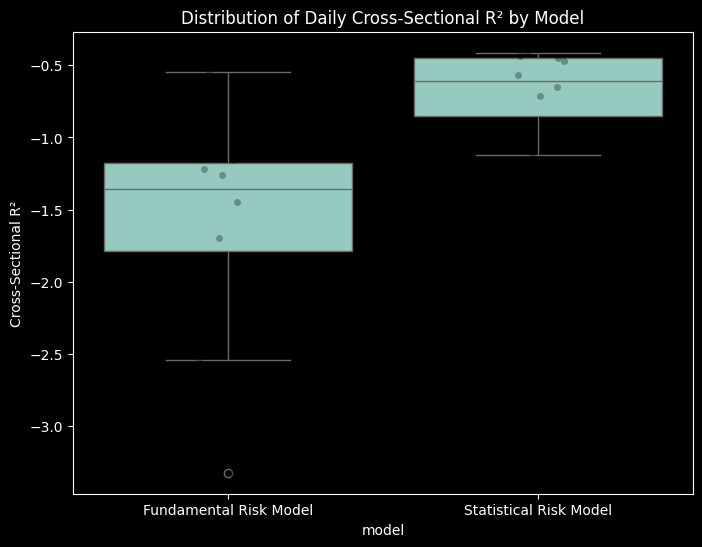

,Model,Mean R²,Std R²,Min R²,Max R²,Stability
0,Fundamental Risk Model,-1.558502,0.851384,-3.321115,-0.543564,0.453716
1,Statistical Risk Model,-0.679908,0.269995,-1.119278,-0.413133,0.602894


In [13]:
validator.plot_real_vs_predicted(model_name='Fundamental Risk Model', ci_level=0.9)
validator.plot_real_vs_predicted(model_name='Statistical Risk Model', ci_level=0.9)
validator.plot_model_performance(results)
validator.plot_r2_boxplot(results)
display(HTML(validator.generate_performance_report().to_html()))

As expected the vanilla stat model has a slight edge.

#### Now let's use this to run a simple portfolio optimization, where we have a linear objective with a momentum target, while minimizing factor risk.

In [22]:
#create some dummy signal which we can target
from signals.momentum import build_momentum_signal
signal_df = build_momentum_signal(returns_df)

#set up optimization params (v basic)
from portfolio_opt.cvxpy_wrapper import CvxpyWrapper
from portfolio_opt.objectives.factor_risk_objective import RiskObjectiveType
from portfolio_opt.objectives import FactorRiskObjective, LinearObjective
from portfolio_opt.objectives import FactorRiskObjective
from portfolio_opt.constraints import SetUpConstraint, BasketLongNotionalConstraint, BasketShortNotionalConstraint,TurnoverConstraint

target = (signal_df.iloc[-1]); target.name = 'COST'
basket_notional = 10_000_000;reference_value = 1e5;initial = portfolio_w
instruments = pd.concat([stat_risk_model.get_beta(),target],axis=1)

### Optimize with a Statistical Factor Risk Model
wrapper = CvxpyWrapper()
FR = FactorRiskObjective(stat_risk_model);FR.risk_objective_type = RiskObjectiveType.VARIANCE
FR.add_objective(wrapper, instruments)
LinearObjective("COST").add_objective(wrapper, instruments)
SetUpConstraint().add_constraint(wrapper, instruments, initial, reference_value)
BasketShortNotionalConstraint(upper=basket_notional, lower=0.0).add_constraint(wrapper, instruments, reference_value)
BasketLongNotionalConstraint(upper=basket_notional, lower=0.0).add_constraint(wrapper, instruments, reference_value)
TurnoverConstraint(upper=basket_notional).add_constraint(wrapper, instruments, reference_value)
stat_opt, stat_sol = wrapper.solve(solver="CPLEX", verbose=False)
### Optimize with a Fundamental Factor Risk Model
wrapper = CvxpyWrapper()
FR = FactorRiskObjective(fund_risk_model);FR.risk_objective_type = RiskObjectiveType.VARIANCE
FR.add_objective(wrapper, instruments)
LinearObjective("COST").add_objective(wrapper, instruments)
SetUpConstraint().add_constraint(wrapper, instruments, initial, reference_value)
BasketShortNotionalConstraint(upper=basket_notional, lower=0.0).add_constraint(wrapper, instruments, reference_value)
BasketLongNotionalConstraint(upper=basket_notional, lower=0.0).add_constraint(wrapper, instruments, reference_value)
TurnoverConstraint(upper=basket_notional).add_constraint(wrapper, instruments, reference_value)
fund_opt, fund_sol = wrapper.solve(solver="CPLEX", verbose=False)
##

result = (pd.DataFrame([fund_sol["global_weights"],stat_sol["global_weights"]], index=['Fundamental Risk Model', 'Statistical Risk Model'],
             columns=instruments.index).T * reference_value).sort_values(by='Fundamental Risk Model',ascending=False)
result.iplot(kind='bar')
summary = result.apply(lambda x: [x[x>0].sum(), x[x<0].sum()]).T
summary.columns = ['Long', 'Short']
summary.iplot(kind='bar',barmode='overlay',colors=['#228B22', '#B22222'],opacity=0.7)

We observe a broadly consistent behavior, with the Stat model slightly more neutral.

- Let's backtest the 2 models over a period of time, vs an equally weighted portfolio.

In [15]:
from plotting.portfolio_opt import replicate_exposures_across_dates,PortfolioDashboard

non_opt_positions = pd.Series([200000]*len(portfolio_w.index), index=portfolio_w.index) #10mil notional
historcal_exposures_df = replicate_exposures_across_dates(returns_df, exposures_df)

models_dict = {
  "Non-Optimized": {"solution": {"positions": non_opt_positions},"risk_model": None,"fitter": None,"exposures": None},
  "Statistical Risk Model": {"solution": {"positions": pd.Series(stat_sol["global_weights"], index=portfolio_w.index) * reference_value},"risk_model": stat_risk_model,"fitter": StatisticalModelFitter(),
      "exposures": None},
  "Fundamental Risk Model": {"solution": {"positions": pd.Series(fund_sol["global_weights"], index=portfolio_w.index) * reference_value},"risk_model": fund_risk_model,
                             "fitter": FundamentalModelFitter(freq="monthly", ewma_half_life=60.0, robust=True, chunked=False,max_workers=18,force_psd=True),"exposures": historcal_exposures_df},}

def DynamicPortfolioOptimizationFunc_USD(
        risk_model,
        instruments: pd.DataFrame,
        current_positions: pd.Series,
        reference_value: float = 1e5, #defined here 
        basket_notional: float = 10_000_000 #defined here
    ) -> pd.Series:
    current_positions_solver_units = current_positions / reference_value
    wrapper = CvxpyWrapper()
    FactorRiskObjective(risk_model).add_objective(wrapper, instruments)
    LinearObjective("COST").add_objective(wrapper, instruments)
    SetUpConstraint().add_constraint(wrapper, instruments,current_positions_solver_units,reference_value)
    BasketShortNotionalConstraint(upper=basket_notional*3, lower=0.0).add_constraint(wrapper, instruments, reference_value)
    BasketLongNotionalConstraint(upper=basket_notional*3, lower=0.0).add_constraint(wrapper, instruments, reference_value)
    TurnoverConstraint(upper=basket_notional).add_constraint(wrapper, instruments, reference_value )
    _opt, sol = wrapper.solve(solver="CPLEX", verbose=False)
    new_positions_solver_units = pd.Series(sol["global_weights"], index=instruments.index)
    new_positions = new_positions_solver_units * reference_value    
    return new_positions
dash = PortfolioDashboard(
        returns_df=returns_df,
        base_portfolio_dollars = non_opt_positions,
        models_dict= models_dict,
        static_holdings=False,
        re_optimize_frequency=21,
        re_fit_factor_models=False,
        alpha_time_series=signal_df,
        solver_func = DynamicPortfolioOptimizationFunc_USD,
        initial_cash = 10_000_000 
)
dash.build_dashboard()
